<a href="https://colab.research.google.com/github/nathan-lioe/SkinScan/blob/main/UM_horizon_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch.nn as nn
import numpy as np
import time
import os
from PIL import Image
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights

from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split,Subset,WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

## Downloading Dataset

In [2]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [00:17<00:00, 368MB/s]
100% 5.20G/5.20G [00:17<00:00, 314MB/s]


In [3]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

## Data Exploration and Preprocessing

In [4]:
df = pd.read_csv('HAM10000_metadata.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [6]:
print(df.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


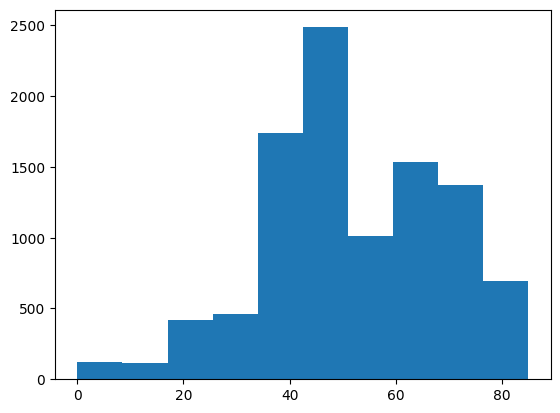

In [7]:
plt.hist(df['age'])
plt.show()

In [8]:
df['age'] = df['age'].fillna(df['age'].median())

In [9]:
print(df.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [10]:
print(df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [11]:
def get_image_path(image_id):
    img_path = f"HAM10000_images_part_1/{image_id}.jpg"
    if not os.path.exists(img_path):
        img_path = f"HAM10000_images_part_2/{image_id}.jpg"
    return img_path

In [12]:
df['image_path'] = df['image_id'].apply(get_image_path)

In [13]:
categories = sorted(df['dx'].unique())
label_to_index = {label: index for index, label in enumerate(categories)}
index_to_label = {index: label for index, label in enumerate(categories)}
print("Categories:", categories)
print("Label to Index:", label_to_index)

Categories: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Label to Index: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Data Transformation

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Add this
    transforms.RandomVerticalFlip(),    # Add this
    transforms.RandomRotation(degrees=(-20, 20)),  # Add this
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Add this
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
class DermaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.metadata = df
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['image_path']
        image = Image.open(img_path)
        label_str = self.metadata.iloc[idx]['dx']
        label_index = label_to_index[label_str]
        label = torch.tensor(label_index)

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
initial_dataset = DermaDataset(df, transform=None)

In [17]:
train_size = int(0.8 * len(initial_dataset))
val_size = int(0.1 * len(initial_dataset))
test_size = len(initial_dataset) - train_size - val_size

train_idx, val_idx, test_idx = random_split(range(len(initial_dataset)), [train_size, val_size, test_size])

print(f"Length of initial_dataset: {len(initial_dataset)}")
print(f"Length of train_idx: {len(train_idx)}")
print(f"Length of val_idx: {len(val_idx)}")
print(f"Length of test_idx: {len(test_idx)}")

Length of initial_dataset: 10015
Length of train_idx: 8012
Length of val_idx: 1001
Length of test_idx: 1002


In [18]:
train_dataset = Subset(initial_dataset, train_idx)
val_dataset = Subset(initial_dataset, val_idx)
test_dataset = Subset(initial_dataset, test_idx)

In [19]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [20]:
weight = df
class_counts = weight['dx'].value_counts()

In [21]:
class_weights = 1.0 / class_counts

In [22]:
class_weights = class_weights / class_weights.sum()
class_weights

,count
dx,
nv,0.006570
mel,0.039582
bkl,0.040086
bcc,0.085709
akiec,0.134724
vasc,0.310244
df,0.383084


In [23]:
sample_weights = weight['dx'].map(class_weights).values

In [24]:
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)
sampler = WeightedRandomSampler(weights=sample_weights_tensor[train_idx],
                                num_samples=len(train_dataset),
                                replacement=True)

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Visualize current data

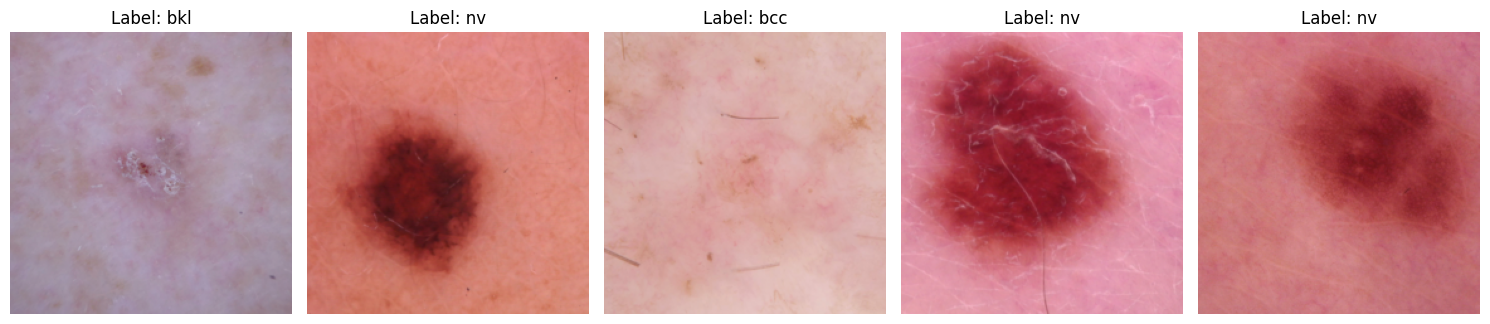

In [27]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
train_dataset.transform = train_transform  # Ensure you apply transformations

for i in range(num_samples):
    image, label = train_dataset[i]  # Get a sample and its label
    image = image.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = image.numpy()  # Convert to numpy array for easier manipulation
    image = np.clip((image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {categories[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model and training setup => ResNet50


In [28]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

number_features = model.fc.in_features
model.fc = nn.Linear(number_features, len(categories))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [30]:
model = model.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

## Training Phase


In [32]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [33]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=25):
    since = time.time()
    early_stopping = EarlyStopping(patience=7, verbose=True)

    best_model = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]", unit="batch") as pbar:
                for inputs, labels in pbar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)

                    pbar.set_postfix({"loss": running_loss / total_samples, "acc": (running_corrects.double() / total_samples).item()})


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                scheduler.step(epoch_loss)
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = model.state_dict()

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)
    return model

In [34]:
from tqdm import tqdm
num_epochs = 75
trained_model = train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=num_epochs)

Epoch 1/75
----------


Epoch 1/75 [train]: 100%|██████████| 251/251 [00:21<00:00, 11.77batch/s, loss=0.525, acc=0.819]


train Loss: 0.5251 Acc: 0.8186


Epoch 1/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.89batch/s, loss=0.676, acc=0.731]


val Loss: 0.6758 Acc: 0.7313
Validation loss decreased (inf --> 0.675803).  Saving model ...

Epoch 2/75
----------


Epoch 2/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.62batch/s, loss=0.241, acc=0.915]


train Loss: 0.2412 Acc: 0.9154


Epoch 2/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.89batch/s, loss=0.474, acc=0.834]


val Loss: 0.4740 Acc: 0.8342
Validation loss decreased (0.675803 --> 0.474028).  Saving model ...

Epoch 3/75
----------


Epoch 3/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.21batch/s, loss=0.174, acc=0.94]


train Loss: 0.1736 Acc: 0.9401


Epoch 3/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.92batch/s, loss=0.602, acc=0.8]


val Loss: 0.6015 Acc: 0.8002
EarlyStopping counter: 1 out of 7

Epoch 4/75
----------


Epoch 4/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.53batch/s, loss=0.117, acc=0.961]


train Loss: 0.1170 Acc: 0.9607


Epoch 4/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.94batch/s, loss=0.514, acc=0.832]


val Loss: 0.5136 Acc: 0.8322
EarlyStopping counter: 2 out of 7

Epoch 5/75
----------


Epoch 5/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.78batch/s, loss=0.0935, acc=0.97]


train Loss: 0.0935 Acc: 0.9704


Epoch 5/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.75batch/s, loss=0.473, acc=0.845]


val Loss: 0.4730 Acc: 0.8452
Validation loss decreased (0.474028 --> 0.473039).  Saving model ...

Epoch 6/75
----------


Epoch 6/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.30batch/s, loss=0.0914, acc=0.969]


train Loss: 0.0914 Acc: 0.9687


Epoch 6/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.59batch/s, loss=0.452, acc=0.863]


val Loss: 0.4520 Acc: 0.8631
Validation loss decreased (0.473039 --> 0.452006).  Saving model ...

Epoch 7/75
----------


Epoch 7/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.17batch/s, loss=0.0776, acc=0.977]


train Loss: 0.0776 Acc: 0.9767


Epoch 7/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.75batch/s, loss=0.531, acc=0.826]


val Loss: 0.5312 Acc: 0.8262
EarlyStopping counter: 1 out of 7

Epoch 8/75
----------


Epoch 8/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.34batch/s, loss=0.0646, acc=0.979]


train Loss: 0.0646 Acc: 0.9793


Epoch 8/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.93batch/s, loss=0.664, acc=0.806]


val Loss: 0.6640 Acc: 0.8062
EarlyStopping counter: 2 out of 7

Epoch 9/75
----------


Epoch 9/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.25batch/s, loss=0.0682, acc=0.976]


train Loss: 0.0682 Acc: 0.9763


Epoch 9/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 12.09batch/s, loss=0.6, acc=0.827]


val Loss: 0.6001 Acc: 0.8272
EarlyStopping counter: 3 out of 7

Epoch 10/75
----------


Epoch 10/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.42batch/s, loss=0.0533, acc=0.982]


train Loss: 0.0533 Acc: 0.9823


Epoch 10/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.91batch/s, loss=0.487, acc=0.85]


val Loss: 0.4867 Acc: 0.8501
EarlyStopping counter: 4 out of 7

Epoch 11/75
----------


Epoch 11/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.24batch/s, loss=0.0601, acc=0.979]


train Loss: 0.0601 Acc: 0.9794


Epoch 11/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.86batch/s, loss=0.6, acc=0.828]


val Loss: 0.6005 Acc: 0.8282
EarlyStopping counter: 5 out of 7

Epoch 12/75
----------


Epoch 12/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.45batch/s, loss=0.0476, acc=0.985]


train Loss: 0.0476 Acc: 0.9845


Epoch 12/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 12.10batch/s, loss=0.537, acc=0.843]


val Loss: 0.5367 Acc: 0.8432
EarlyStopping counter: 6 out of 7

Epoch 13/75
----------


Epoch 13/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.46batch/s, loss=0.0226, acc=0.992]


train Loss: 0.0226 Acc: 0.9924


Epoch 13/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.57batch/s, loss=0.428, acc=0.869]


val Loss: 0.4285 Acc: 0.8691
Validation loss decreased (0.452006 --> 0.428465).  Saving model ...

Epoch 14/75
----------


Epoch 14/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.92batch/s, loss=0.014, acc=0.997]


train Loss: 0.0140 Acc: 0.9969


Epoch 14/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.85batch/s, loss=0.415, acc=0.88]


val Loss: 0.4146 Acc: 0.8801
Validation loss decreased (0.428465 --> 0.414597).  Saving model ...

Epoch 15/75
----------


Epoch 15/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.76batch/s, loss=0.00907, acc=0.998]


train Loss: 0.0091 Acc: 0.9976


Epoch 15/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.81batch/s, loss=0.406, acc=0.882]


val Loss: 0.4056 Acc: 0.8821
Validation loss decreased (0.414597 --> 0.405579).  Saving model ...

Epoch 16/75
----------


Epoch 16/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.47batch/s, loss=0.00975, acc=0.998]


train Loss: 0.0097 Acc: 0.9983


Epoch 16/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.82batch/s, loss=0.419, acc=0.886]


val Loss: 0.4192 Acc: 0.8861
EarlyStopping counter: 1 out of 7

Epoch 17/75
----------


Epoch 17/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.38batch/s, loss=0.00579, acc=0.999]


train Loss: 0.0058 Acc: 0.9986


Epoch 17/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.79batch/s, loss=0.41, acc=0.881]


val Loss: 0.4095 Acc: 0.8811
EarlyStopping counter: 2 out of 7

Epoch 18/75
----------


Epoch 18/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.78batch/s, loss=0.00527, acc=0.999]


train Loss: 0.0053 Acc: 0.9989


Epoch 18/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 12.01batch/s, loss=0.467, acc=0.876]


val Loss: 0.4674 Acc: 0.8761
EarlyStopping counter: 3 out of 7

Epoch 19/75
----------


Epoch 19/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.29batch/s, loss=0.00574, acc=0.999]


train Loss: 0.0057 Acc: 0.9985


Epoch 19/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 12.09batch/s, loss=0.47, acc=0.881]


val Loss: 0.4698 Acc: 0.8811
EarlyStopping counter: 4 out of 7

Epoch 20/75
----------


Epoch 20/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.50batch/s, loss=0.00409, acc=0.999]


train Loss: 0.0041 Acc: 0.9988


Epoch 20/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.69batch/s, loss=0.446, acc=0.877]


val Loss: 0.4458 Acc: 0.8771
EarlyStopping counter: 5 out of 7

Epoch 21/75
----------


Epoch 21/75 [train]: 100%|██████████| 251/251 [00:20<00:00, 12.37batch/s, loss=0.00381, acc=1]


train Loss: 0.0038 Acc: 0.9995


Epoch 21/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.73batch/s, loss=0.448, acc=0.881]


val Loss: 0.4484 Acc: 0.8811
EarlyStopping counter: 6 out of 7

Epoch 22/75
----------


Epoch 22/75 [train]: 100%|██████████| 251/251 [00:19<00:00, 12.57batch/s, loss=0.00543, acc=0.999]


train Loss: 0.0054 Acc: 0.9990


Epoch 22/75 [val]: 100%|██████████| 32/32 [00:02<00:00, 11.71batch/s, loss=0.448, acc=0.874]

val Loss: 0.4484 Acc: 0.8741
EarlyStopping counter: 7 out of 7
Early stopping
Training complete in 8m 25s
Best val Acc: 0.886114


In [35]:
torch.save(trained_model.state_dict(), 'model_skin.pth')


## Evaluate

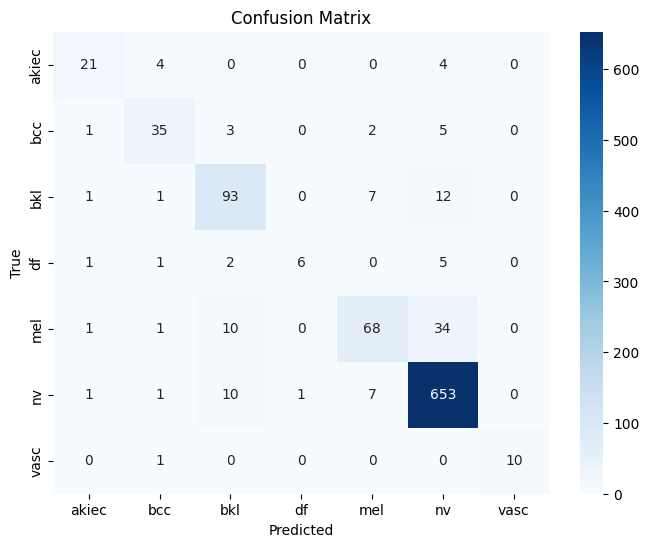

Overall Accuracy: 0.8842

Classification Report:
              precision    recall  f1-score   support

       akiec       0.81      0.72      0.76        29
         bcc       0.80      0.76      0.78        46
         bkl       0.79      0.82      0.80       114
          df       0.86      0.40      0.55        15
         mel       0.81      0.60      0.69       114
          nv       0.92      0.97      0.94       673
        vasc       1.00      0.91      0.95        11

    accuracy                           0.88      1002
   macro avg       0.85      0.74      0.78      1002
weighted avg       0.88      0.88      0.88      1002



In [37]:
model.load_state_dict(torch.load("model_skin.pth", map_location=device, weights_only=True))
model.eval()

def evaluate_model(model, dataloader, categories):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)


    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    accuracy = (true_labels == predicted_labels).mean()
    print(f'Overall Accuracy: {accuracy:.4f}')


    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=categories))

evaluate_model(model, test_dataloader, categories)